<div style="text-align:center;">
    <h1 style="font-size: 50px; margin: 0px; margin-bottom: 5px;"> Chirp mass distribution of binary black holes (BBHs)</h1>
    <h2 style="margin:0px; margin-bottom: 5px;">COMPAS methods paper Figure 16</h2>
    <p style="text-align:center;">A notebook for reproducing the Chirp mass distribution in the COMPAS methods paper.</p>
</div>

<img src="https://compas.science/images/COMPAS_CasA.png" style="width:50%; display:block; margin:auto; margin-bottom:20px">

This notebook reproduces Figure 10 of the COMPAS Paper (_arXiv_: https://arxiv.org/abs/2109.10352;   Team COMPAS et al. 2021).


****
## Data 
The data used for this figure is publicly available at: https://zenodo.org/record/5655483

This data set contains the output of 10,000,000 binaries evolved using COMPAS 02.21.00, using adaptive importance sampling (STROOPWAFEL, Broekgaarden et al. 2019), sampling from a metallicity uniform in $\log(Z) \in [10^{-4},0.03]$. More details can be found in `Run_Details.txt`.



***
### Data reporduction
The data can be reproduced by running version `02.21.00` of COMPAS, using the file `stroopwafel_interface.py`, that reads in the `Fig16_pythonSubmit.py` (contained in this folder).



The rates were calculated by running ```FastCosmicIntegration.py```  from COMPAS's post-processing tools, with the following flags altered from their default values:


```:::bash
    python FastCosmicIntegration.py  --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight mixture_weight --zstep 0.01 --sens O3 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 
```


For a more detailed explanation of the workings of COMPAS's post-processing tools, please work through the Jupyter Notebook tutorials in the `postProcessing` directory.

## Making the Figure:

### Let's start with paths and libraries :)
* If you would like to use this script for your own COMPAS Output, change `fileLoc` and `filename` to point to your data set.

In [1]:
import numpy as np
import h5py as h5
from astropy.table import Table, Column

import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

from scipy import stats
import time 
import sys 

######################################
fileLoc    = '/Users/lieke/Downloads/output/'
filename   = 'COMPAS_Output_reduced.h5'
######################################
##PLOT setttings
plt.rc('font', family='serif')

from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




# Read the data

In [2]:
 ################################################
## Open hdf5 file
File        = h5.File(fileLoc + filename ,'r')

# The group that contains the rate data
rate_key = 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0'
################################################
## Read merger rate related data
DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
redshifts                 = File[rate_key]['redshifts'][()] # Redshifts at which the rates were calculated
O1_detection_rate         = File[rate_key]['detection_rateO3'][()] # detection rate for O1 sensitivity 

# Read the DCO masses, Select only merging BBHs
Mass1              = File['BSE_Double_Compact_Objects']['Mass(1)'][DCO_mask]
Mass2              = File['BSE_Double_Compact_Objects']['Mass(2)'][DCO_mask]
M_moreMassive      = np.maximum(Mass1, Mass2)
M_lessMassive      = np.minimum(Mass1, Mass2)


File.close()

# Set values

In [3]:
######################################
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
# Calculate the chrip mass
Mchirp = Mchirp(M_moreMassive, M_lessMassive)

# Use the detection rates at O1 sensitivity
ratePerSys_observed = np.sum(O1_detection_rate, axis=1)
mask = Mchirp < 100 # Set maximum plotted chirp mass to be 100 Msun

# Set grid in chirp mass
binsMchirp  = np.linspace(0, 40, 20)
binwidth    = np.diff(binsMchirp)
center_bins = (binsMchirp[1:] + binsMchirp[:-1]) / 2.0

#################################
# The data that you will plot
x_vals  = Mchirp
Weights = ratePerSys_observed
Bins    = binsMchirp

#################################
# Would you like to bootstrap your data?
# Warning, this is slow
bootstrap  = True
bootstraps =  100

#################################
# What colour should your plot be
colors  = 'grey'

In [4]:
#################################
# Nice little progressbar script 
# to know how far you are with bootstrapping
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

# Plot the Figure

Bootstrapping: [############################################################] 100/100


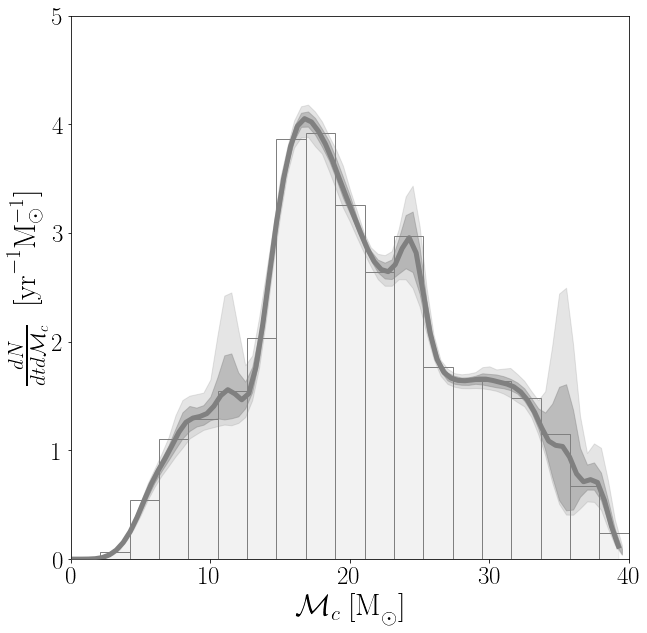

In [5]:
#########################################
# Start plotting
fig, ax = plt.subplots(figsize = (10,10))


########################
# Plot the Histogram   
hist, bin_edge = np.histogram(x_vals, weights = Weights, bins = Bins)
ax.bar(center_bins, hist/binwidth, width= binwidth, color='white', fill=False, edgecolor=colors,lw = 1.) 

########################
# Add the KDE
kernel = stats.gaussian_kde(x_vals, bw_method=0.1, weights=Weights)
# plot the KDE at these x-ticks
x_KDE = np.arange(0,40,0.5) 
center_KDEbins = (x_KDE[:-1] + x_KDE[1:])/2.
# Re-normalise the KDE
y_vals = kernel(center_KDEbins)*sum(hist)

# Plot it and fill the area underneath the curve :)
ax.plot(center_KDEbins, y_vals, lw=5, color=colors)
ax.fill_between(center_KDEbins, y1=0, y2=y_vals, color=colors, alpha = 0.1)


########################
# Bootstrap to obtain sampling errors
if bootstrap:
    indices = np.arange(len(x_vals))
    hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
    
    for b in progressbar( range(len(hist_vals)), "Bootstrapping: "):
        boot_index = np.random.choice(indices, size=len(indices), replace=True)

        kernel       = stats.gaussian_kde(x_vals[boot_index], bw_method=0.1, weights=Weights[boot_index])
        Hist, _      = np.histogram(x_vals[boot_index], bins=Bins,weights=Weights[boot_index],density=False)

        hist_vals[b] = kernel(x_KDE)*sum(Hist)

    # calculate 1- and 2- sigma percentiles
    percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
    median = np.percentile(hist_vals, [50], axis=0)
    
    ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors, zorder = 11) # 1-sigma
    ax.fill_between(x_KDE, percentiles[2], percentiles[3],alpha=0.2, color=colors, zorder = 10) # 2-sgima    

    
#########################################
# plot values
ax.set_xlim(0,40)
ax.set_ylim(0,5)

ax.set_xlabel('$\mathcal{M}_c \ \mathrm{[M}_{\odot} \mathrm{]}$', fontsize = 30)
ax.set_ylabel('$\\frac{dN}{dt d\mathcal{M}_{c}}$ \ $\mathrm{[yr}^{-1}\mathrm{M}_{\odot}^{-1}\mathrm{]}$', fontsize = 30)

plt.savefig('./MchirpO3detection_.pdf', bbox_inches='tight')

plt.show()

